In [2]:
# Imports and Setup
import os
import re
import json
import requests
import pandas as pd
from typing import List, Dict, Any, Optional, Union, Type
from dataclasses import dataclass
from enum import Enum
import textwrap

# LangGraph and LangChain imports
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage, AIMessage
from langchain_text_splitters import CharacterTextSplitter

from langchain.tools import tool

# LLM imports
from llama_index.llms.ollama import Ollama

import json
import urllib.request
import urllib.error
import urllib.parse
from urllib.parse import quote, urlsplit, urlunsplit
import urllib.request
import urllib.error

from dataclasses import dataclass
from typing import List, Dict, Any, Optional

from bs4 import BeautifulSoup
from ddgs import DDGS

In [3]:
# Configuration and LLM Setup
REQUEST_TIMEOUT = 180
MODEL_NAME = "qwen2.5:14b"

# Initialize Ollama LLM
llm = Ollama(
    model=MODEL_NAME, 
    request_timeout=REQUEST_TIMEOUT
)

# Test LLM connection
test_response = llm.complete("Hello")
print(f"LLM initialized: {test_response.text[:50]}...")

def pprint(text):
    wrapped_lines = textwrap.wrap(text, width=130)
    for line in wrapped_lines:
        print(line)

## TODO: Use ChatEngine
# chat_model = SimpleChatEngine.from_defaults(llm=llm)

LLM initialized: Hello! How can I assist you today?...


In [4]:
def create_plan(task: str) -> str:
    """
    Given a task, determine a step-by-step action plan of what needs to be done to accomplish this task and output the answer/result. 
    The most important actions that are taken: 
     1. Define the goal: what result is asked to be produced.
     2. List the steps: provide a short explanation for each action that needs to be taken.       
    """
    
    prompt = f"""
You are an expert project planner. Your task is to create a concise, step-by-step action plan to accomplish the user's goal.

User's Goal:
---
{task}
---

Instructions:
1. Clarify the Core Objective: Start by rephrasing the user's goal as a single, clear, and specific objective.
2. Develop a Chronological Action Plan: Break down the objective into a logical sequence of high-level steps.

Guiding Principles for the Plan:
- Tool-Agnostic: Focus on the action required, not the specific tool to perform it (e.g., use "Gather data on market trends" instead of "Search Google for market trends").
- Information First: The initial step should almost always be to gather and analyze the necessary information before taking further action.
- S.M.A.R. Steps: Each step must be Specific, Measurable, Achievable, and Relevant. The focus is on the logical sequence, not specific deadlines.
- Concise: Include only the critical steps needed to reach the objective.

Example Output Format (ALWAS **JSON** ):
{{
  "objective": "Plan and execute a one-day offsite event for a team of 10 people focused on team building and strategic planning.",
  "plan": [
    "Gather requirements including budget, potential dates, and key goals for the offsite from team leadership",
    "Research and shortlist suitable venues and activity options that fit the budget and goals",
    "Create a detailed agenda and budget proposal for approval",
    "Book the selected venue, catering, and activities upon approval",
    "Send out official invitations and manage attendee confirmations and dietary requirements",
    "Finalize all logistical details and communicate the full itinerary to the team"
  ]
}}
where
  "objective" 's value in the json is a clear, one-sentence summary of the end goal,
  "plan" 's value in the json is a list **ALWAYS SEPARATED BY PYTHON NEWLINE CHARCTER** like 
  [
    A short explanation of the first logical step", 
    A short explanation of the next step that follows from the first",
    And so on..."
  ]
"""
    task_response = llm.complete(prompt)

    return task_response.text

@dataclass
class Task:
    question: str
    objective: str
    plan: list[str]


def set_task(task:str) -> str: 
    task_plan_response = create_plan(task)

    # Assume llm outputs smth json-like with the correct keys.
    result = json.loads(task_plan_response)

    return Task(
      question=task,
      objective=result["objective"],
      plan=result["plan"],
    )

In [ ]:
import json
from dataclasses import dataclass
from typing import List, Dict


class BaseAgentCapability:
    """Base class for all agent capabilities."""
    name: str  # Defines that all subclasses should have a 'name' class attribute

    def __init__(self, activity: str = None):
        """
        Initializes the capability with a specific activity.

        Args:
            activity: The specific action to be performed.
        """
        self.activity = activity

    def __repr__(self) -> str:
        """Provides a clean string representation of the object."""
        # 'self.name' correctly accesses the class attribute from the instance
        return f"{self.__class__.__name__}(name='{self.name}', activity='{self.activity}')"

class AgentCapabilityDeepWebSearch(BaseAgentCapability):
    """Capability for performing a deep web search."""
    name = "deep_web_search"

class AgentCapabilityVideoProcessor(BaseAgentCapability):
    """Capability for processing video files."""
    name = "video_processing"

class AgentCapabilityAudioProcessor(BaseAgentCapability):
    """Capability for processing audio files."""
    name = "audio_processing"

class AgentCapabilityImageProcessor(BaseAgentCapability):
    """Capability for processing image files."""
    name = "image_processing"

class AgentCapabilityStructuredDataProcessor(BaseAgentCapability):
    """Capability for processing structured data."""
    name = "structured_data_processing"

class AgentCapabilityUnstructuredDataProcessor(BaseAgentCapability):
    """Capability for processing unstructured text."""
    name = "unstructured_data_processing"

class AgentCapabilityCodeMathWritter(BaseAgentCapability):
    """Capability for writing code or solving math problems."""
    name = "code_math_writing"

class CapabilityPlan:
    """A structured plan outlining the sequence of capabilities and actions."""
    subplan: List[BaseAgentCapability]


CAPABILITY_MAP: Dict[str, Type[BaseAgentCapability]] = {
    AgentCapabilityDeepWebSearch.name: AgentCapabilityDeepWebSearch,
    AgentCapabilityVideoProcessor.name: AgentCapabilityVideoProcessor,
    AgentCapabilityAudioProcessor.name: AgentCapabilityAudioProcessor,
    AgentCapabilityImageProcessor.name: AgentCapabilityImageProcessor,
    AgentCapabilityStructuredDataProcessor.name: AgentCapabilityStructuredDataProcessor,
    AgentCapabilityUnstructuredDataProcessor.name: AgentCapabilityUnstructuredDataProcessor,
    AgentCapabilityCodeMathWritter.name: AgentCapabilityCodeMathWritter,
}

def json_to_capability_plan(json_data: dict) -> CapabilityPlan:
    """
    Convert JSON response into a CapabilityPlan with proper capability objects.
    """
    subplan = []
    for step in json_data["subplan"]:
        cap_name = step["capability"]
        activity = step["activity"]

        if cap_name not in CAPABILITY_MAP:
            raise ValueError(f"Unknown capability: {cap_name}")

        cap_class = CAPABILITY_MAP[cap_name]
        capability = cap_class(activity=activity)
        subplan.append(capability)

    return CapabilityPlan(subplan=subplan)

@dataclass
class CapabilityPlan:
    """A structured plan outlining the sequence of capabilities and actions."""
    subplan: List[Dict[str, str | str]]


def determine_capabilities(task: str, attachments: List[str] = None) -> CapabilityPlan:
    """
    Analyzes a task and generates a sequential execution plan using available capabilities.

    Args:
        task (str): The description of the task to be performed.
        attachments (list[str]): A list of file names related to the task.

    Returns:
        CapabilityPlan: A dataclass containing the ordered list of sub-tasks.
    """
    attachment_info = ""
    if attachments:
        attachment_info = f"\n\nAttachments provided: {', '.join(attachments)}"

    # TODO: is this fine to map capability to an agent one-to-one? 
    planning_prompt = f"""
You are a highly intelligent planning agent. Your primary function is to analyze a user's task and create a precise, step-by-step execution plan using a predefined set of capabilities.

**Your Task:**
Analyze the provided task and create a sequential plan to accomplish it. The plan should be a list of steps, where each step defines the capability to use and the specific activity to perform.

**Capabilities:**
- `{AgentCapabilityDeepWebSearch.name}`: Find, evaluate, and download web content (e.g., articles, documents). This capability is for search and downloading web resources only, not for processing the content or getting any answers on the content.
- `{AgentCapabilityVideoProcessor.name}`: Download video, extract frames or audio from a video file for further analysis.
- `{AgentCapabilityAudioProcessor.name}`: Download audio, transcribe speech, identify sounds, or analyze properties of an audio file.
- `{AgentCapabilityImageProcessor.name}`: Download image, analyze an image to identify objects, read text (OCR), or understand its content.
- `{AgentCapabilityStructuredDataProcessor.name}`: Analyze, query, or visualize data from structured files like Parquet, CSV, JSON, or databases.
- `{AgentCapabilityUnstructuredDataProcessor.name}`: Analyze, summarize, extract information from, or answer questions about raw text or documents (e.g., PDFs, TXT files, retrieved web content).
- `{AgentCapabilityCodeMathWritter.name}`: Generate or execute code, solve mathematical problems, or perform complex logical operations and computations.

Instructions:
Deconstruct the Task -> Assign Capabilities for each step -> Define the Activity for each step (i.e.,write a clear and concise description of the specific action to be performed using the chosen capability)

Example 1: Simple Fact Lookup
Task: "What is the boiling point of water at sea level?"
Output:
{{
  "subplan": [
    {{
      "capability": "{AgentCapabilityDeepWebSearch.name}",
      "activity": "Search for the boiling point of water at sea level"
    }},
    {{
      "capability": "{AgentCapabilityUnstructuredDataProcessor.name}",
      "activity": "Analyze the downloaded web resources and find the reference to the boiling point temperature."
    }}
  ]
}}

Example 2: Multi-step Information Retrieval and Analysis

Task: "Find the Q2 2025 earnings report for NVIDIA and tell me what their 'Gaming' division revenue was."
Output:
{{
  "subplan": [
    {{
      "capability": "{AgentCapabilityDeepWebSearch.name}",
      "activity": "Search for and download NVIDIA's official Q2 2025 earnings report document and download it."
    }},
    {{
      "capability": "{AgentCapabilityUnstructuredDataProcessor.name}",
      "activity": "Analyze the downloaded earnings report to find and extract the revenue figure for the 'Gaming' division."
    }}
  ]
}}

---
Begin Plan Generation

Task: "{task}"
Attachments: "{attachment_info}"

Respond in this exact JSON format:
{{
  "subplan": [
    {{
      "capability": "...",
      "activity": "..."
    }},
    {{
      "capability": "...",
      "activity": "..."
    }}
  ]
}}
"""
    response = llm.complete(planning_prompt)
    response_text = response.text.strip()

    result = json.loads(response_text)

    return json_to_capability_plan(result)

In [6]:
question = "Who did the actor who played Ray in the Polish-language version of Everybody Loves Raymond play in Magda M."

task = set_task(question)
pprint(task.__str__())

# Iterate over the plan: get a single task of the plan together with the objective 
current_plan_step = task.plan[0]
task_step = f"You need to FOCUS ON: {current_plan_step}. When your global objective which you SHOULD NOT FOCUS ON: {task.objective}."  
capability_plan = determine_capabilities(task=task_step)
pprint(capability_plan.__str__())

Task(question='Who did the actor who played Ray in the Polish-language version of Everybody Loves Raymond play in Magda M.',
objective="Identify the role played by the actor who portrayed Ray in the Polish-language version of 'Everybody Loves Raymond' in
the film 'Magda M'.", plan=["Gather information about the Polish-language cast and crew involved in the production of 'Everybody
Loves Raymond'.", 'Identify the actor who played Ray in this adaptation.', "Research the filmography of the identified actor to
find their role in 'Magda M'."])
CapabilityPlan(subplan=[AgentCapabilityDeepWebSearch(name='deep_web_search', activity='Search for and download information about
the Polish-language cast and crew involved in the production of 'Everybody Loves Raymond'.'),
AgentCapabilityUnstructuredDataProcessor(name='unstructured_data_processing', activity='Analyze the downloaded web resources to
gather details on the Polish-language cast and crew without focusing on identifying any specific actor's

In [7]:
##################
# web_search_agent 
##################

@dataclass
class ContentResource:
    """A unified dataclass for handling any type of resource that is being used for a task (web document, pdf file ).

    Attributes:
        provided_by: who supplied the resource (user or an agent/tool call) # <=> as_answer_to
        content: The main text content of the web page. Can be None if not yet downloaded.
        link: The unique URL or file path for the resource.
        metadata: A dictionary containing additional information, such as search result data.
    """
    provided_by: str 
    content: Optional[str]
    link: str
    metadata: Dict[str, Any]

@dataclass
class WebSearchResult: 
    link: str 
    metadata: dict

def question_to_queries(question: str, max_queries: int = 2) -> List[str]:
    """Converts a user question into a list of optimized search engine queries.

    Note:
        This function requires a Large Language Model (LLM) to generate queries.
        The `llm.complete()` call is a placeholder for your model's inference logic.

    Args:
        question: The user's input question.
        max_queries: The maximum number of search queries to generate.

    Returns:
        A list of string queries optimized for a search engine.
    """
    prompt = f"""
    Create a list of general search engine queries for the following question: "{question}".

    Make sure that:
    - Your output is a list separated by a "|" character and nothing else.
    - You provide a MAXIMUM of {max_queries} search engine queries.
    - Each query is SHORT and precise.

    Example Output:
    Large urban population areas in Europe|Biggest cities in Europe
    """
    llm_response = llm.complete(prompt)
    response_text = llm_response.text

    return response_text.strip().split("|")


def duckduckgo_search(query: str, max_results: int = 2) -> List[WebSearchResult]:
    """Performs a DuckDuckGo search and returns results as WebResource objects.

    Args:
        query: The search query string.
        max_results: The maximum number of search results to retrieve.

    Returns:
        A list of WebResource objects, where 'content' is None and 'metadata'
        contains the search result details.
    """
    found_resources = []
    with DDGS() as ddgs:
        results = list(ddgs.text(query, max_results=max_results))
        if not results:
            print(f"⚠️ No search results found for '{query}'")
            return []

        for i, result in enumerate(results):
            resource = WebSearchResult(
                link=result.get('href', 'No URL'),
                metadata={
                    "search_order": i,
                    "web_page_title": result.get('title', 'No title'),
                    "web_page_summary": result.get('body', 'No description'),
                    "query": query
                }
            )
            found_resources.append(resource)

    return found_resources


def drop_non_unique_link(resources: List[ContentResource|WebSearchResult]) -> List[ContentResource|WebSearchResult]:
    """Removes duplicate WebResource objects based on their 'link' attribute.

    Args:
        resources: A list of WebResource objects.

    Returns:
        A new list of WebResource objects with duplicates removed.
    """
    seen_links = set()
    unique_resources = []
    for resource in resources:
        if resource.link and resource.link not in seen_links:
            unique_resources.append(resource)
            seen_links.add(resource.link)
    return unique_resources


def extract_clean_text(raw_html: str) -> str:
    """Extracts clean, readable text from raw HTML content.

    This function removes scripts, styles, navigation, and other non-content
    elements, then cleans up whitespace.

    Args:
        raw_html: The raw HTML content of a webpage.

    Returns:
        The extracted and cleaned plain text.
    """
    soup = BeautifulSoup(raw_html, 'html.parser')
    # Remove elements that typically do not contain main content
    for element in soup(["script", "style", "nav", "footer", "header", "aside"]):
        element.decompose()

    # Extract text and clean up whitespace
    text = soup.get_text(separator=" ")
    lines = (line.strip() for line in text.splitlines())
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    return ' '.join(chunk for chunk in chunks if chunk)


import httpx
from urllib.parse import quote, urlsplit, urlunsplit

def download_content(resource: WebSearchResult) -> str:
    """
    Downloads the HTML from a resource's link and populates its 'content' field.
    This version includes robust URL encoding and safe error printing.
    """
    if not resource.link or not resource.link.startswith('http'):
        return resource

    # For this example, let's assume _encode_url_path is defined elsewhere
    # encoded_link = _encode_url_path(resource.link)
    response = httpx.get(resource.link, timeout=15)
    charset = response.encoding or 'utf-8'
    html_bytes = response.content
    html_content = html_bytes.decode(charset)

    return extract_clean_text(html_content)

def web_search(question: str, links_per_query: int = 2) -> List[ContentResource]:
    """Orchestrates the full web search process for a given question.

    This process includes:
    1. Converting the question into search queries.
    2. Searching the web to find resources.
    3. Downloading and extracting text content from each resource.

    Args:
        question: The user's question.
        links_per_query: The number of web links to retrieve for each search query.

    Returns:
        A list of WebResource objects, with their 'content' field populated.
    """
    # 1. Generate search queries from the question
    candidate_queries = question_to_queries(question)
    print(f"\nGenerated queries: {candidate_queries}")

    # 2. Search for relevant sources for each query
    all_sources = []
    for query in candidate_queries:
        search_results_for_query = duckduckgo_search(query, links_per_query)
        all_sources.extend(search_results_for_query)

    # 3. Filter out any duplicate resources found by different queries
    unique_search_results = drop_non_unique_link(all_sources)
    print(f"\nFound {len(unique_search_results)} unique web resources.")

    # 4. Download content for each unique resource
    final_resources = []
    for search in unique_search_results:
        content = download_content(search)
        populated_resource = ContentResource(
            provided_by=web_search.__name__,
            content=content,
            link=search.link,
            metadata=search.metadata
        )
        if populated_resource.content: # Only keep resources where content was successfully downloaded
            final_resources.append(populated_resource)

    return final_resources

In [ ]:
##################################
# unstructered_text_processor 
##################################

import json
from dataclasses import dataclass
from typing import List
from langchain.text_splitter import CharacterTextSplitter


@dataclass
class ShortAnswer:
    """A dataclass to hold a structured answer from the LLM.

    Attributes:
        answer: The direct answer to the task, or "not found" if unavailable.
        clarification: A brief explanation of the context or reason for the answer.
    """
    answer: str = "not found"
    clarification: str = "No information processed yet."


def construct_short_answer(task: str, context: str) -> ShortAnswer:
    """Summarizes a context and provides a structured short answer to a task.

    This function sends the context and a task to an LLM, asking it to synthesize
    the information and return the result in a specific JSON format.

    Note:
        This function requires a configured LLM client, represented here as `llm`.

    Args:
        task: The specific question or instruction to be performed.
        context: A string containing the text/information to be analyzed.

    Returns:
        A ShortAnswer dataclass instance containing the answer and clarification.
    """
    prompt = f"""
    You are presented with a list of expert answers from different sources that you need to summarize.

    LIST:
    {context}

    Based **ONLY** on that list and without any additional assumptions from your side, perform the task specified.

    TASK:
    {task}

    Your answer should be in a valid JSON format like so:
    {{
        "answer": "<a single number, word, or phrase which is the answer to the question>",
        "clarification": "<a very short mention of what the answer is based on>"
    }}

    Rules:
        - If the text contains the complete answer → put the exact answer in "answer".
        - If the text contains no relevant information → put "answer": "not found".
        - If the text contains some but not all information → put "answer": "not found".
        - The "clarification" must mention the relevant part of the text and explain briefly.
    """

    llm_response = llm.complete(prompt)
    response_text = llm_response.text
    response_text = response_text.strip()

    data = json.loads(response_text)
    return ShortAnswer(
        answer=data.get("answer", "did-not-parse"),
        clarification=data.get("clarification", "did-not-parse.")
    )

def task_with_text_llm(task: str, text: str) -> str:
    """Performs a task on a single block of text using an LLM.

    This function is a general-purpose processor that asks an LLM to execute
    an instruction based only on the provided context.

    Note:
        This function requires a configured LLM client, represented here as `llm`.

    Args:
        task: The instruction to be performed (e.g., "Summarize this text").
        text: The context text for the LLM to work with.

    Returns:
        The raw string response from the LLM.
    """
    prompt = f"""
    Perform the instruction/task in the user's question.
    Use only the information provided in the context.

    TASK:
    {task}

    CONTEXT:
    {text}

    **IMPORTANT**: If the text does not include the SPECIFIC information required for the task, output "NOT FOUND".
    Otherwise, provide the direct answer.
    """
    llm_result = llm.complete(prompt)
    return llm_result.text


def text_process_llm(task: str, text: str, chunk_size: int = 10000, chunk_overlap: int = 500) -> List[str]:
    """Splits a large text into chunks and processes each chunk with an LLM.

    This is useful for analyzing documents that are too large to fit into a
    single LLM context window. Each chunk is processed independently.

    Args:
        task: The task to perform on each chunk of text.
        text: The entire body of text to be processed.
        chunk_size: The maximum number of characters in each chunk.
        chunk_overlap: The number of characters to overlap between consecutive chunks.

    Returns:
        A list of string responses, with one response for each processed chunk.
    """
    text_splitter = CharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separator=""  
    )
    chunks = text_splitter.split_text(text)

    responses = []
    for chunk in chunks:
        chunk_response = task_with_text_llm(task, chunk)
        if "NOT FOUND" not in chunk_response:
            responses.append(chunk_response)

    return responses

In [9]:
# for capability_step in capability_plan.subplan:
#     match capability_step["capability"]:
#         case AgentCapability.DEEP_WEB_SEARCHER:
#             web_resources = web_search(capability_step["activity"])
#         case AgentCapability.UNSTRUCTURED_DATA_PROCESSOR:
#             # TODO: how to pass things around? 
#             pass
#         case _:
#             print("Finished processing")

# for web_resource in web_resources:
#     print(web_resource.link)

# text = [web_resource.content for web_resource in web_resources]
# text_process_llm(task=capability_plan.subplan[1]["activity"], text=text)

In [10]:
@dataclass
class Attachments:
    # provided_by: who supplied the resource (user or an agent/tool call) # <=> as_answer_to
    provided_by: str 
    filepath: str 
    description: str

class ExecutionState(TypedDict):
    # Identifies what the original question/task given, which objective it got transferred to, what the plan to get an answer is
    task: Task
    # status of whether it is completed or not 
    completed: bool
    # order index of the step of the task's plan that is being executed 
    step: int
    # the step of the plan that is being executed 
    subtask: str 
    # capability plan for this task 
    capability_plan: CapabilityPlan
    # capability plan step order 
    capability_plan_step: int
    # all files that might be needed to execute the task 
    attachments: list[Attachments]
    # all text resources that might be needed to execute the task
    resources: list[ContentResource]
    # tools that already got called
    # TODO: see if this is needed 
    tools_called: str  

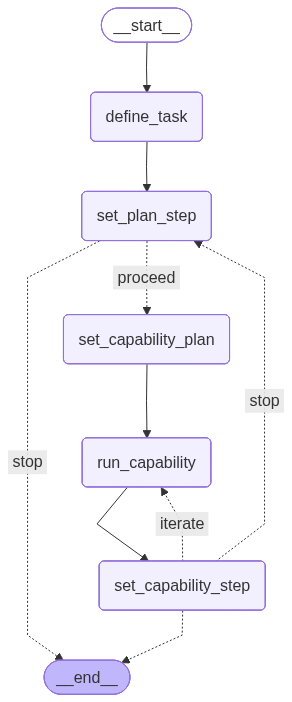

In [14]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(state_schema=ExecutionState)

def init_state(ask: str, attachments: str = None, resources: str = None) -> ExecutionState:
    # TODO: should I be using LLM to convert attachments/resources to acceptable format?
    # TODO: implement proper handling of attachments and resources 
    return ExecutionState(
        ask=ask,
        completed=False,
        task=None,
        step=None,
        attachments=None
    )

def set_plan_step(state: ExecutionState) -> ExecutionState: 
    """  
    Determine which state is being executed. 
    """
    state["step"] = 0 if None else state["step"] + 1
         
    return state

def check_completion(state: ExecutionState) -> str:
    plan_length = len(state["task"].plan)
    if state["step"] < plan_length:
        return "proceed"
    else:
        return "stop"

def set_capability_plan(state: ExecutionState) -> ExecutionState: 
    state["capability_plan"] = determine_capabilities(state["task"].plan[state["step"]])
    state["capability_plan_step"] = 0

    return state

def set_capability_step(state: ExecutionState) -> ExecutionState:
    if state["capability_plan_step"] is None:
        state["capability_plan_step"] = 0 
    else:
        state["capability_plan_step"] += 1 

    return state

def check_capability_step(state:ExecutionState) -> ExecutionState: 
    capability_plan_length = len(state["capability_plan"])
    if state["capability_plan_step"] < capability_plan_length:
        # run the next capability 
        return "iterate"        
    else: 
        # signal that we need to move over to the next state
        return "stop" 


def run_capability(state: ExecutionState) -> str: 
    ask = state["capability_plan"][state["capability_plan_step"]]
    resources, attachments = state["capability_plan"][state["capability_plan_step"]].run(ask)
    if attachments:
        state["attachments"].extend(attachments)
    if resources:
        state["resources"].extend(resources)

    return state


def run_web_search(state: ExecutionState) -> ExecutionState:
    resources = web_search(state["subtask"])
    state["resources"].extend(resources)

    return state 

workflow.add_node("define_task", set_task)
workflow.add_node("set_plan_step", set_plan_step)
workflow.add_node("set_capability_plan", set_capability_plan)
workflow.add_node("run_capability", run_capability)
workflow.add_node("set_capability_step", set_capability_step)

workflow.add_edge(START, "define_task")
workflow.add_edge("define_task", "set_plan_step")

workflow.add_conditional_edges(
    "set_plan_step",
    check_completion,
    {
        "proceed": "set_capability_plan",
        "stop": END,
    }
)

workflow.add_edge("set_capability_plan", "run_capability")
workflow.add_edge("run_capability", "set_capability_step")


workflow.add_conditional_edges(
    "set_capability_step", 
    check_capability_step,
    {
        "iterate":"run_capability",
        "stop": "set_plan_step",
    }
)

# Compile the graph
research_graph = workflow.compile()

from IPython.display import Image, display

# Display the graph
display(Image(research_graph.get_graph().draw_mermaid_png()))

In [12]:
# Q: "How many at bats did the Yankee with the most walks in the 1977 regular season have that same season?"
# Take the first step of the plan 
# resp = web_searcher.run("Who of Yankees had the most walks in 1977 regular season?")

In [13]:
# print("Agent is running... waiting for the result...")
final_result = resp.result()
pprint(resp.__str__())

NameError: name 'resp' is not defined

In [ ]:
# First node: create task 

# Second node: create capability plan for the first step 

# 

In [ ]:
# Based on capabilities let an agent do the task 

# Combine task and objective and hand over the execution to the agent 

In [ ]:
# Agent's work flow:
#  1. Compose query 
#  2. Do search & collect results 
#  3. Download and process results
#  4. Save results 
#  5. Produce summery of how the data looks like and where to find it. 

In [ ]:
#  Define agents 
from llama_index.core.agent import ReActAgent, FunctionCallingAgent
from llama_index.core.tools import FunctionTool

In [ ]:
# question = "Who did the actor who played Ray in the Polish-language version of Everybody Loves Raymond play in Magda M."

# task = define_task(question)
# pprint(task.__str__())
